# 2-colour imaging: RecB-Halo + Nucleoid (Sytox)

In [1]:
from pyberries.data import DatasetPool, get_histogram
import seaborn.objects as so
import seaborn as sns
from seaborn import plotting_context
import matplotlib.pyplot as plt
import pandas as pd

data = (DatasetPool(path='./../../BACMMAN_datasets',
                    dsList=['240424_1', '240612_1', '240620_1',
                            '240424_2', '240612_2', '240620_2',
                            '240424_3', '240612_3', '240619_1',
                            '240424_4', '240612_4', '240619_2',
                            '240606_1', '240606_3', '240619_3',
                            '240606_2', '240606_4', '240619_4',
                            ],
                    groups=['WT, 0 ng/ml', 'WT, 0 ng/ml', 'WT, 0 ng/ml',
                            'WT, 30 ng/ml', 'WT, 30 ng/ml', 'WT, 30 ng/ml',
                            'Δ$recA$, 0 ng/ml', 'Δ$recA$, 0 ng/ml', 'Δ$recA$, 0 ng/ml',
                            'Δ$recA$, 30 ng/ml', 'Δ$recA$, 30 ng/ml', 'Δ$recA$, 30 ng/ml',
                            '$recB_{1080}$, 0 ng/ml', '$recB_{1080}$, 0 ng/ml', '$recB_{1080}$, 0 ng/ml',
                            '$recB_{1080}$, 30 ng/ml', '$recB_{1080}$, 30 ng/ml', '$recB_{1080}$, 30 ng/ml'
                            ],
                    metadata='DateTime'
                    )
        .heatmap_metrics(object_name=['Nucleoid', 'RecB_spots'])
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        .assign(Time_min=lambda df: df.Time_min + 15)
        .bin_column(col='Time_min', binsize=15, binlabels='left')
        .split_column(col='Group', new_cols=['Strain', 'Cipro'], delimiter=', ')
        .assign(Cipro=lambda df: df.Cipro.astype('category').cat.set_categories(['0 ng/ml', '30 ng/ml'], ordered=True),
                Strain=lambda df: df.Strain.astype('category').cat.set_categories(['WT', 'Δ$recA$', '$recB_{1080}$'], ordered=True)
                )
        )

Dataset 240424_1 (group WT, 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240612_1 (group WT, 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240620_1 (group WT, 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240424_2 (group WT, 30 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240612_2 (group WT, 30 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240620_2 (group WT, 30 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid', 'SM_traces']
Dataset 240424_3 (group Δ$recA$, 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240612_3 (group Δ$recA$, 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240619_1 (group Δ$recA$, 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'Re

## General statistics

Number of cells

In [2]:
display(data
        .Bacteria_large
        .query('Frame == 0')
        .agg({'Indices':'count'})
        )

Indices    15029
dtype: int64

Number of spots

In [3]:
display(data
        .RecB_spots
        .agg({'Indices':'count'})
        )

Indices    58331
dtype: int64

Number of nucleoids

In [4]:
display(data
        .Nucleoid
        .query('Frame == 0')
        .agg({'Indices':'count'})
        )

Indices    20831
dtype: int64

Number of cells (without WT)

In [2]:
display(data
        .Bacteria_large
        .query('Frame == 0 and Strain != "WT"')
        .agg({'Indices':'count'})
        )

Indices    7804
dtype: int64

Number of spots (without WT)

In [3]:
display(data
        .RecB_spots
        .query('Strain != "WT"')
        .agg({'Indices':'count'})
        )

Indices    36595
dtype: int64

Number of nucleoids (without WT)

In [4]:
display(data
        .Nucleoid
        .query('Frame == 0  and Strain != "WT"')
        .agg({'Indices':'count'})
        )

Indices    11215
dtype: int64

## Fraction of the cell occupied by the nucleoid

##### Supp. Figure 16

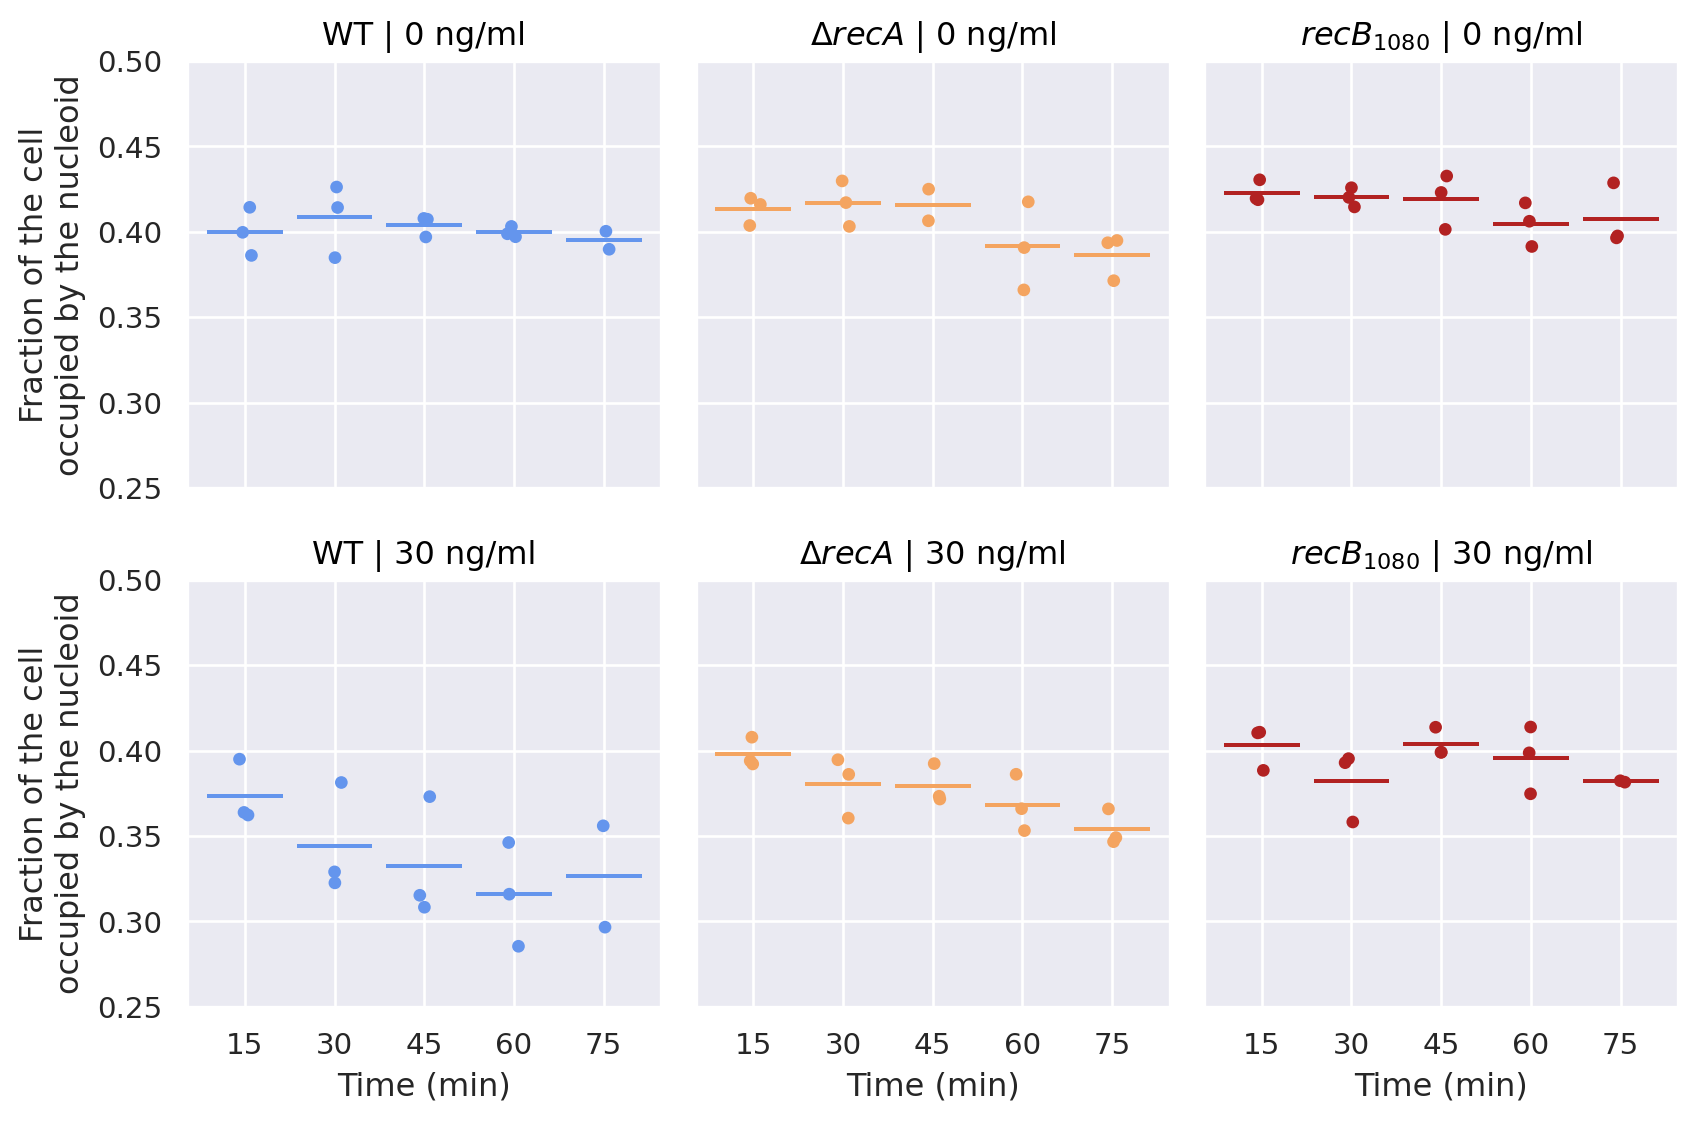

In [2]:
df = (data
      .add_from_child(object_name='Bacteria_large', child='Nucleoid', col='Nucleoid_size', agg='sum')
      .Bacteria_large
      .assign(frac_nucleoid=lambda df: df.Nucleoid_size / df.Area)
      .groupby(['Group', 'Cipro', 'Strain', 'Dataset', 'Time_min_bin'], observed=True)
      .agg({'frac_nucleoid':'mean'})
      )

(
      so.Plot(df, x='Time_min_bin', y='frac_nucleoid', color='Strain')
      .facet(col='Strain', row='Cipro')
      .layout(size=(9, 6))
      .add(so.Dash(), so.Agg(), legend=False)
      .add(so.Dots(fillalpha=1, pointsize=4), so.Jitter(), legend=False)
      .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick'],
             order=['WT', 'Δ$recA$', '$recB_{1080}$']), x=so.Continuous().tick(every=15))
      .label(x='Time (min)', y='Fraction of the cell\noccupied by the nucleoid')
      .limit(y=(0.25, 0.5))
      .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/Mutants_nucleoid_compaction.pdf', format='pdf', bbox_inches='tight')
)

In [9]:
df = (data
      .add_from_child(object_name='Bacteria_large', child='Nucleoid', col='Nucleoid_size', agg='sum')
      .Bacteria_large
      .query('Time_min_bin == 75')
      .assign(frac_nucleoid=lambda df: df.Nucleoid_size / df.Area *100)
      .groupby('Group')
      .agg({'frac_nucleoid':['mean', 'std']})
      .round(0)
      )

display(df)

frac_nucleoid      
                            mean   std
Group                                 
RecB1080, 0                 40.0  10.0
RecB1080, 30 ng/mL          38.0   9.0
WT, 0                       39.0   9.0
WT, 30 ng/mL                32.0  11.0
ΔrecA, 0                    38.0  12.0
ΔrecA, 30 ng/mL             35.0  11.0

### Nucleoid/RecB colocalisation

Split by groups, normalised by cell length, cells with 1-2 nucleoids

Without normalisation to cell length:

In [2]:
dx = 0.25

df = (pd.concat([data
                .add_from_parent(object_name='Nucleoid', col='NucleoidCount')
                .apply_filters({'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .Nucleoid
                .dropna()
                .assign(LowerBound=lambda df: df.centerLongCoord - df.NucleoidLength/2,
                        nPoints=lambda df: round(df.NucleoidLength / dx).astype('int')
                        )
                .pipe(lambda df: df.loc[df.index.repeat(df.nPoints)])
                .reset_index(names='id')
                .assign(SubID=lambda df: df.groupby('id')['id'].cumcount() +0.5,
                        Density=lambda df: df.LowerBound + df.SubID *dx,
                        Object='Nucleoid'
                        )
                [['Strain', 'Cipro', 'Dataset', 'Time_min_bin', 'Density', 'Object']],
                data
                .add_from_parent(object_name='RecB_spots', col='NucleoidCount')
                .apply_filters({'RecB_spots': 'TrackLength >= 5', 'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .RecB_spots
                .assign(Object='RecB')
                .rename(columns={'centerLongCoord':'Density'})
                [['Strain', 'Cipro', 'Dataset', 'Time_min_bin', 'Density', 'Object']]
                ])
        .query('Time_min_bin < 90')
        .assign(Time_min_bin=lambda df: df.Time_min_bin.astype('int').astype('str') + ' min')
        )

hist = (get_histogram(df, col='Density', groupby=['Strain', 'Cipro', 'Time_min_bin', 'Object'], density=True, binsize=.2)
        .pipe(lambda df: pd.pivot_table(df, values='proportion', index=['Strain', 'Cipro', 'Time_min_bin', 'Density'], columns='Object'))
        .reset_index()
        )


##### Figure 4D

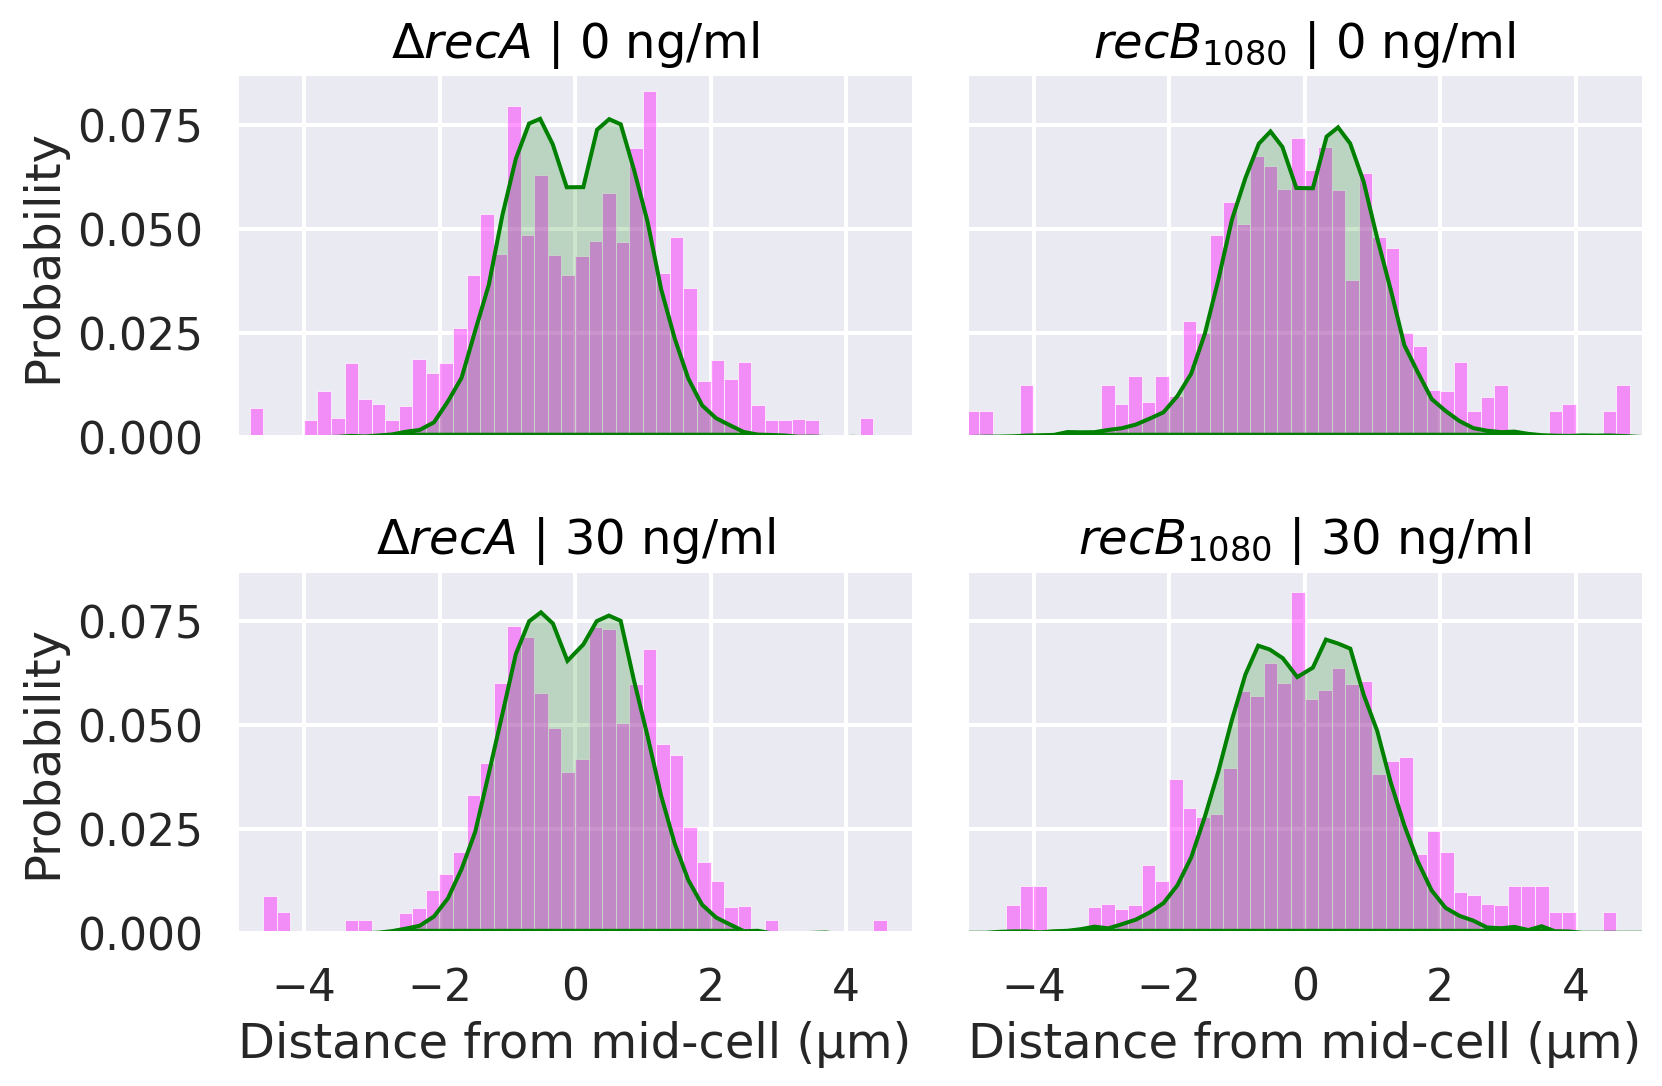

In [4]:
hist = hist.query('Strain != "WT"')

(
    so.Plot(hist, x='Density')
    .facet(row='Cipro', col='Strain', order={'row':['0 ng/ml', '30 ng/ml'], 'col':['Δ$recA$', '$recB_{1080}$']})
    .layout(size=(9,6))
    .add(so.Bars(color='magenta', alpha=.4), so.Agg(),  y='RecB')
    .add(so.Area(color='green'), so.Agg(), y='Nucleoid')
    .scale(x=so.Continuous().tick(every=2))
    .label(x='Distance from mid-cell (µm)', y='Probability')
    .limit(x=(-5, 5), y=(0, None))
    .theme(plotting_context('talk'))
    .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/4_Mutants/Nucleoid_RecB_position.svg', format='svg', bbox_inches='tight')
)

(unpublished)

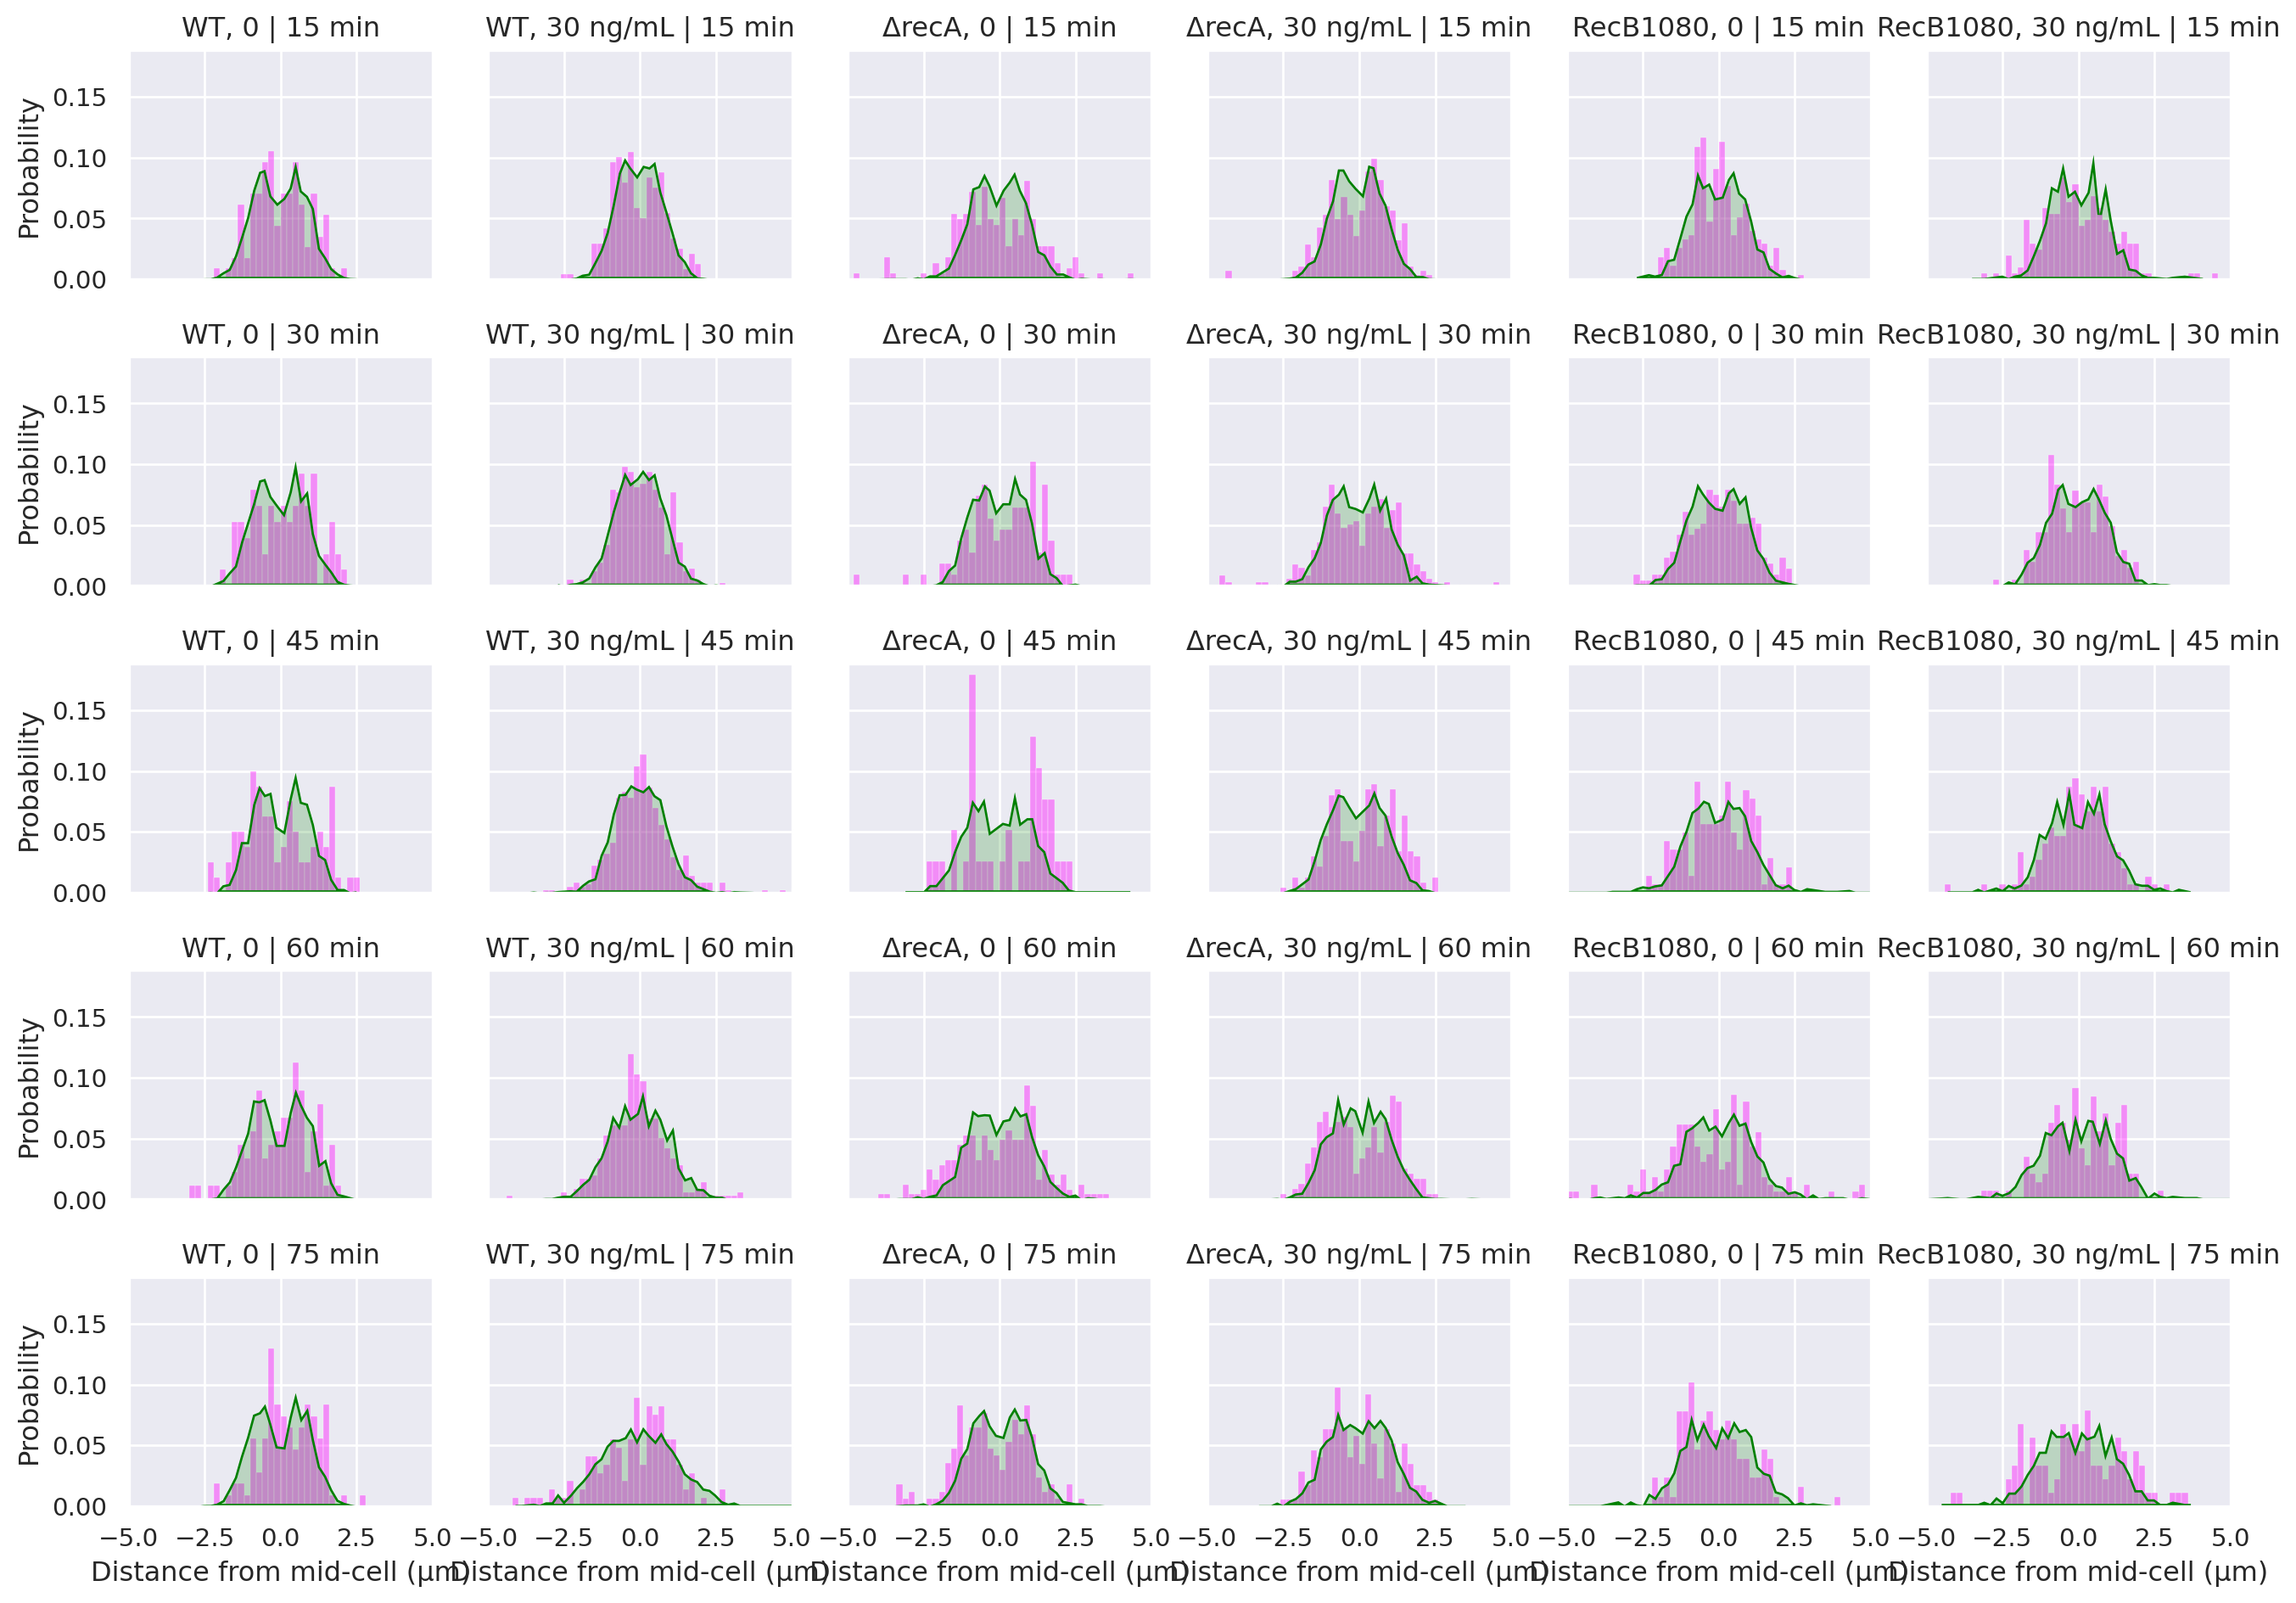

In [23]:
dx = 0.5

df = (pd.concat([data
                .add_from_parent(object_name='Nucleoid', col='NucleoidCount')
                .apply_filters({'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .Nucleoid
                .dropna()
                .assign(LowerBound=lambda df: df.centerLongCoord - df.NucleoidLength/2,
                        nPoints=lambda df: round(df.NucleoidLength / dx).astype('int')
                        )
                .pipe(lambda df: df.loc[df.index.repeat(df.nPoints)])
                .reset_index(names='id')
                .assign(SubID=lambda df: df.groupby('id')['id'].cumcount() +0.5,
                        Density=lambda df: df.LowerBound + df.SubID *dx,
                        Object='Nucleoid'
                        )
                [['Group', 'Strain', 'Cipro', 'Dataset', 'Time_min_bin', 'Density', 'Object']],
                data
                .add_from_parent(object_name='RecB_spots', col='NucleoidCount')
                .apply_filters({'RecB_spots': 'TrackLength >= 5', 'Bacteria_large':'NucleoidCount > 0 and NucleoidCount <= 2'})
                .RecB_spots
                .assign(Object='RecB')
                .rename(columns={'centerLongCoord':'Density'})
                [['Group', 'Strain', 'Cipro', 'Dataset', 'Time_min_bin', 'Density', 'Object']]
                ])
        .query('Time_min_bin < 90')
        .assign(Time_min_bin=lambda df: df.Time_min_bin.astype('int').astype('str') + ' min')
        )

hist = (get_histogram(df, col='Density', groupby=['Group', 'Strain', 'Cipro', 'Time_min_bin', 'Object'], density=True, binsize=.2)
        .pipe(lambda df: pd.pivot_table(df, values='proportion', index=['Group', 'Strain', 'Cipro', 'Time_min_bin', 'Density'], columns='Object'))
        .reset_index()
        )

(
    so.Plot(hist, x='Density')
    .facet(row='Time_min_bin', col='Group', order={'col':['WT, 0 ng/mL', 'WT, 30 ng/mL', '$recA$, 0 ng/mL', '$recA$, 30 ng/mL', '$recB_{1080}$, 0 ng/mL', '$recB_{1080}$, 30 ng/mL']})
    .layout(size=(14,10))
    .add(so.Bars(color='magenta', alpha=.4), so.Agg(),  y='RecB')
    .add(so.Area(color='green'), so.Agg(), y='Nucleoid')
    .label(x='Distance from mid-cell (µm)', y='Probability')
    .limit(x=(-5, 5), y=(0, None))
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/RecB_Nucleoid_position_timepoints.pdf', format='pdf', bbox_inches='tight')
)